In [12]:
#SEGMENTADOR - WATERSHED

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

"""

Función para segmentación por el método de watershed

La segmentación por watershed es un algoritmo basado en la topografía de la imagen,
donde las regiones de interés se consideran como "cuencas" que se llenan de agua desde los "mínimos" (regiones oscuras) hasta que se encuentran con otras cuencas,
formando así los bordes de las regiones segmentadas.

La función `segmentacion_watershed` toma una imagen en escala de grises y un número de iteraciones para las operaciones morfológicas.

La funcion se utiliza con el proposito de obtener o resaltar los bordes de la estrutura que se encuentra en el primer plano de la imagen.

Args:
    imagen (numpy.ndarray): Imagen en escala de grises a segmentar.
    iteraciones (int): Número de iteraciones para las operaciones morfológicas.

"""

def segmentacion_watershed(imagen, iteraciones):
    plt.figure()
    plt.subplot(3, 7, 8)
    plt.title('Imagen Original')
    plt.imshow(imagen, cmap='gray')
    plt.show()

    
    # Primero, necesitamos encontrar los marcadores para las regiones
    _, thresh = cv.threshold(imagen, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    plt.subplot(3, 7, 1)
    plt.title('Imagen Umbralizada')
    plt.imshow(thresh, cmap='gray')
    plt.axis('off')
    plt.show()

    # Definir kernel para operaciones morfológicas
    kernel = np.ones((3, 3), dtype=np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=iteraciones)
    plt.subplot(3, 7, 2)
    plt.title('Apertura Morfológica')
    plt.imshow(opening, cmap='gray')
    plt.axis('off')
    plt.show()
   
    sure_bg = cv.erode(opening, kernel, iterations=iteraciones)
    plt.subplot(3, 7, 3)
    plt.title('Fondo Seguro')
    plt.imshow(sure_bg, cmap='gray')
    plt.axis('off')
    plt.show()

    dist_transform = cv.distanceTransform(thresh, cv.DIST_L2, 5)
    plt.subplot(3, 7, 4)
    plt.title('Transformada de Distancia')
    plt.imshow(dist_transform, cmap='gray')
    plt.axis('off')
    plt.show()

    _, sure_fg = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    plt.subplot(3, 7, 5)
    plt.title('Primer Plano')
    plt.imshow(sure_fg, cmap='gray')
    plt.axis('off')
    plt.show()

    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    #Marcadores
    _, markers = cv.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    plt.subplot(3, 7, 6)
    plt.title('Marcadores de esctructuras conectadas')
    plt.imshow(markers, cmap='gray')
    plt.axis('off')
    plt.show()

    # Aplicar el algoritmo de watershed
    markers = cv.watershed(cv.cvtColor(sure_bg, cv.COLOR_GRAY2BGR), markers)
    plt.subplot(3, 7, 7)
    plt.title('Marcadores después de watershed')
    plt.imshow(markers, cmap='gray')
    plt.axis('off')
    plt.show()
    
    imagen[markers == -1] = 255  # Marcar los bordes con blanco

    return imagen

In [13]:
# SEGMENTADOR - SEMILLAS

import cv2 as cv
import numpy as np
from collections import deque

"""

Función para segmentación por el método de Semilla

La segmentación por semilla es un algoritmo que comienza con uno o más píxeles "semilla" y expande la región alrededor de estas semillas
basándose en un criterio de similitud, como la intensidad de píxeles.

La función `segmentacion_semilla` toma una lista de semillas, un umbral de similitud, una imagen en escala de grises y la conectividad (4 o 8).

La funcion apunto a resaltar la estructura que se encuentra en el primer plano de la imagen.

Args:
    seeds (Lista de tuplas): Lista de coordenadas (x, y) de las semillas.
    threshold (int): Umbral de similitud para incluir píxeles en la región segmentada.
    imagen (numpy.ndarray): Imagen en escala de grises a segmentar.
    conectividad (int): Tipo de conectividad (4 o 8) para definir vecinos.

"""

def segmentacion_semilla(seeds, threshold, imagen, conectividad):
    segmented = np.zeros_like(imagen, dtype=np.uint8) #arreglo de 0's para la segmentacion (negro)
    visited = np.zeros_like(imagen, dtype=bool) #arreglo de booleanos para marcar los pixeles visitados
    height, width = imagen.shape # dimensiones de la imagen

    # Vecinos según conectividad
    if conectividad == 4:
        vecinos = [(-1,0), (1,0), (0,-1), (0,1)]
    else:
        vecinos = [(dx,dy) for dx in [-1,0,1] for dy in [-1,0,1] if not (dx==0 and dy==0)]

    for seed in seeds:
        x, y = seed

        #Se itera por cada una de las semillas definidas
        if not (0 <= x < height and 0 <= y < width):
            print(f"Semilla {seed} fuera de límites (height={height}, width={width})") #se valida que la semilla este dentro de la imagen
            continue

        if visited[x, y]:   #se valida si la semilla x, y ya fue procesada, si ya fue procesada, se mueve a la siguiente 
            continue

        queue = deque()
        queue.append((x, y))
        visited[x, y] = True    # marcar pixel como visitado
        segmented[x, y] = 255   # marcar pixel en la segmentacion blanco
        region_sum = int(imagen[x, y])
        region_count = 1
        while queue:
            px, py = queue.popleft()
            region_mean = region_sum // region_count
            for dx, dy in vecinos:
                nx, ny = px + dx, py + dy
                if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny]:
                    if abs(int(imagen[nx, ny]) - region_mean) < threshold:
                        segmented[nx, ny] = 255
                        visited[nx, ny] = True
                        queue.append((nx, ny))
                        region_sum += int(imagen[nx, ny])
                        region_count += 1
        
        plt.figure()
        plt.subplot(3, 4, seeds.index(seed) + 1)
        plt.title(f'Segmentación para semilla {seed}')
        plt.imshow(segmented, cmap='gray')
        plt.axis('off')
        plt.show()
    return segmented


In [14]:
# DESPLIEGUE DE IMAGENES

import matplotlib.pyplot as plt

def desplegar_imagenes(watershed_img, seeded_img):
    # Mostrar resultados de segmentación
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Segmentacion por Watershed')
    plt.imshow(watershed_img, cmap='gray')
    plt.show()

    plt.subplot(1, 2, 2)
    plt.title('Segmentacion por Semilla')
    plt.imshow(seeded_img, cmap='gray')
    plt.show()

In [15]:
# LECTURA DE IMAGEN MONTERREY Y ESTABLECIMIENTO DE SUS PARAMETROS PARA LA SEGMENTACION

import cv2 as cv
import os
import sys

"imagen de 194 x 259 pixeles)"
def segmentar_imagen_monterrey():
    # Cargar la imagen
    raiz = os.getcwd()
    imgPath = os.path.join(raiz, 'monterrey.jpg')
    img = cv.imread(imgPath)
    gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if img is None:
        print('Error al cargar la imagen')
        sys.exit(1)
    
    seeds = [(25, 25), (100, 100), (125, 125), (150, 200)]  # ajustar semilla(s) y umbral según convenga
    threshold = 45
    conectividad = 4
    iteraciones = 3
    
    res_watershed = segmentacion_watershed(gris, iteraciones)

    res_seeded = segmentacion_semilla(seeds, threshold, gris, conectividad)

    desplegar_imagenes(res_watershed, res_seeded)

In [16]:
# LECTURA DE IMAGEN SUJETO Y ESTABLECIMIENTO DE SUS PARAMETROS PARA LA SEGMENTACION

import cv2 as cv
import os
import sys

"imagen de 183 x 275 pixeles)"
def segmentar_imagen_sujeto():
    # Cargar la imagen
    raiz = os.getcwd()
    imgPath = os.path.join(raiz, 'sujeto.jpg')
    img = cv.imread(imgPath)
    gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if img is None:
        print('Error al cargar la imagen')
        sys.exit(1)
    
    seeds = [(25, 50), (50, 100)] # ajustar semilla(s) y umbral según convenga
    threshold = 35
    iteraciones = 5
    conectividad = 4
    res_watershed= segmentacion_watershed(gris, iteraciones)

    res_seeded = segmentacion_semilla(seeds, threshold, gris, conectividad)

    desplegar_imagenes(res_watershed, res_seeded)

In [17]:
# LECTURA DE IMAGEN LENA Y ESTABLECIMIENTO DE SUS PARAMETROS PARA LA SEGMENTACION

import cv2 as cv
import os
import sys

"imagen de 148 x 163 pixeles"
def segmentar_imagen_lena():
    # Cargar la imagen
    raiz = os.getcwd()
    imgPath = os.path.join(raiz, 'lena.jpg')
    img = cv.imread(imgPath)
    gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if img is None:
        print('Error al cargar la imagen')
        sys.exit(1)
    
    seeds = [(25, 25), (125, 25), (80, 160)]  # ajustar semilla(s) y umbral según convenga
    threshold = 45
    iteraciones = 4
    conectividad = 8
    res_watershed = segmentacion_watershed(gris, iteraciones)

    res_seeded = segmentacion_semilla(seeds, threshold, gris, conectividad)

    desplegar_imagenes(res_watershed, res_seeded)

In [18]:
#CARGA DE IMAGENES EN LOS SEGMENTADORES

def mostrar_imagen_segmentada(*imagenes):
    for imagen in imagenes:
        if imagen == 'monterrey':
            segmentar_imagen_monterrey()
        elif imagen == 'sujeto':
            segmentar_imagen_sujeto()
        elif imagen == 'lena':
            segmentar_imagen_lena()

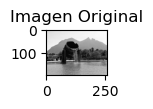

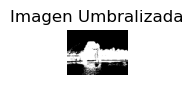

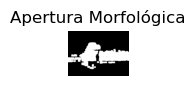

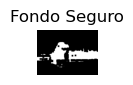

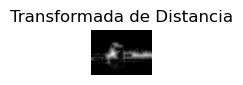

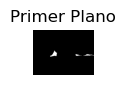

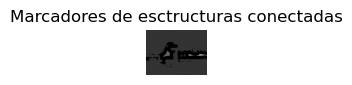

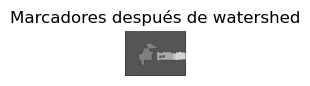

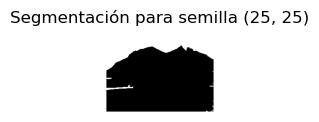

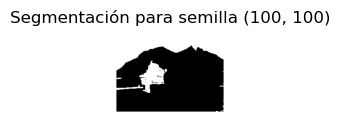

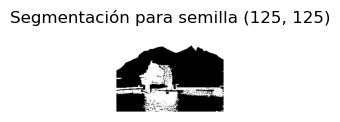

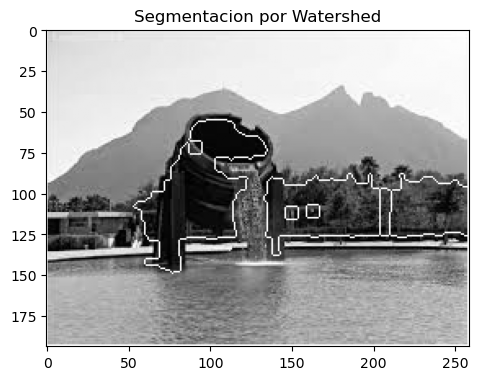

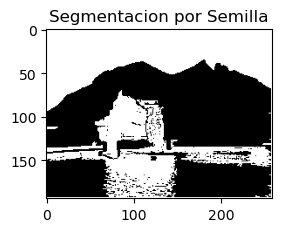

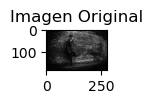

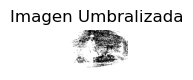

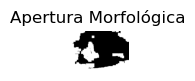

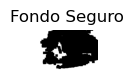

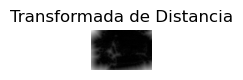

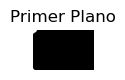

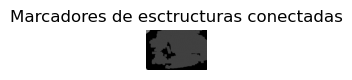

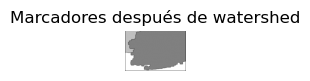

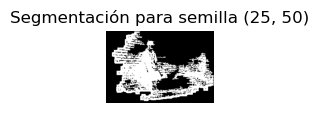

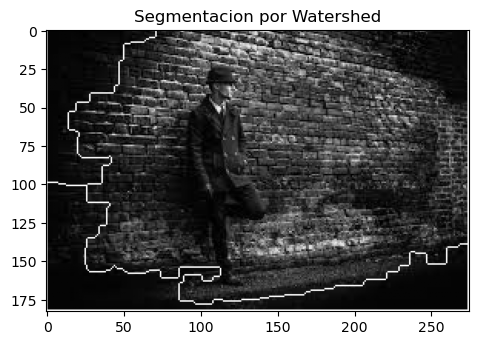

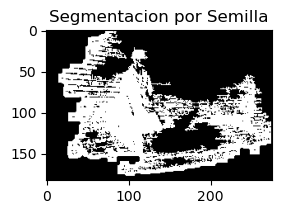

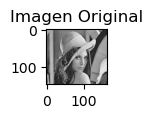

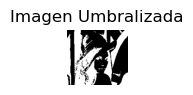

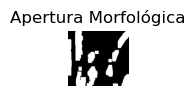

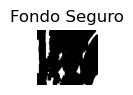

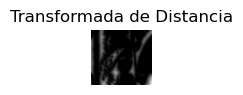

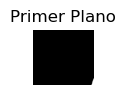

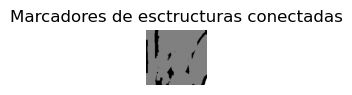

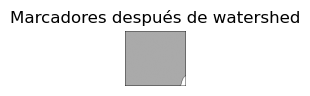

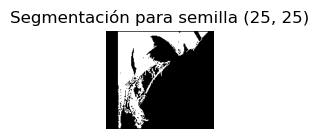

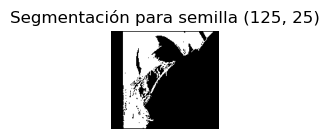

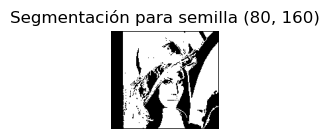

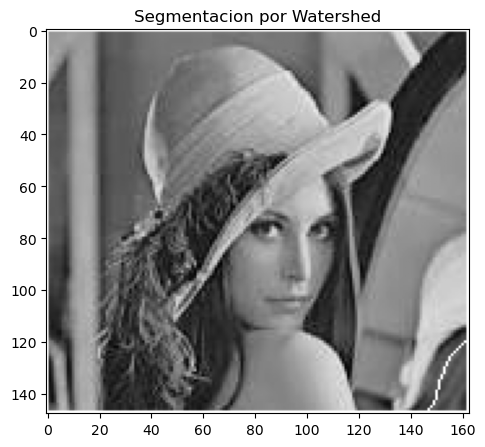

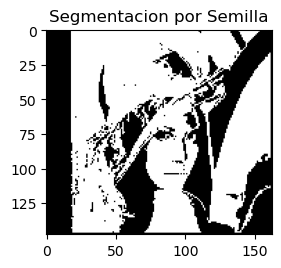

In [19]:
# EJECUCION DE LOS SEGMENTADORRES EN LAS IMAGENES SELCCIONADAS

"""
Ejercicios de segmentacion usando diferentes metodos: 
    watershed
    Seeds

-Se trata de segmentar tres imagenes diferentes: monterrey.jpg, sujeto.jpg y lena.jpg esto con la finalidad de resaltar las estructuras en primer plano de un fondo complejo.
-Se pueden cambiar las semillas y los umbrales para observar diferentes resultados.
-Las imagenes deben estar en el mismo directorio que este script.
-Cada metodo de segmentacion se visualiza en una ventana diferente.
-Cada vez que se llama a la funcion mostrar_imagen_segmentada con el nombre de la imagen, se ejecuta el proceso de segmentacion para esa imagen.
    el metodo se puede llamar haciendo referencia a las 3 imagenes, lo que mostrara las segmentaciones de las 3 imagenes en ventanas separadas.

Conclusiones:
-Tras analizar los resultados obtenidos se determina que los segmentos mas definidos se obtienen con el metodo de Semillas, seguido del metodo de watershed

Imagenes utilizadas:
monterrey.jpg (https://www.facebook.com/MonterreyEnImagenes/)
sujeto.jpg (https://alvinmint.com/generador-de-historias-aleatorias/)
lena.jpg (https://verne.elpais.com/verne/2019/10/21/articulo/1571661515_258318.html)

"""
mostrar_imagen_segmentada('monterrey', 'sujeto', 'lena')

In [20]:
# SEGMENTADOR DE COLORES RGB
# Este segmentador esta basado en la guia de la PHD. Rebecca Stone, su sitio web: https://realpython.com/team/rstone/
# El segmentador utiliza un rango de colores pre-establecido por el usuario, junto con funciones de opencv para detectar pixeles que se encuentren dentro de este rango de colores, para luego segmentar estos colores de la imagen original

In [21]:
#Librerias necesarias para la ejecucion del codigo
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np

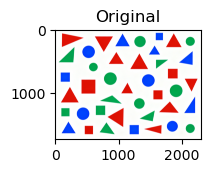

In [22]:
#Se lee la imgen a utilizar y se la covierte del perfil de color BGR al RGB 
image = cv.imread('colors.png')
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original')
plt.show()

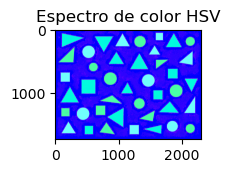

In [23]:
# Se convierte la imgen del perfil de color RGB al HSV para facilitar la deteccion de colores
image_hsv = cv.cvtColor(image_rgb, cv.COLOR_RGB2HSV)

plt.subplot(1, 3, 1)
plt.imshow(image_hsv)
plt.title('Espectro de color HSV')
plt.show()

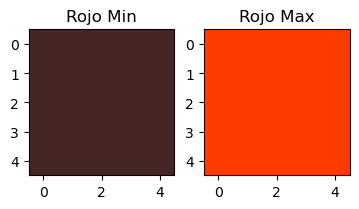

In [24]:
#Se establece el rango de color rojo minimo y maximo ha ser detectado en espectro hsv 
min_rojo = (0, 120, 70)
max_rojo = (10, 255, 255)

#Se crean dos matrices con el color rojo minimo y maximo establecido por el usuario 
matriz_rojo_min = np.full((5, 5, 3), min_rojo, dtype=np.uint8) / 255.0
matriz_rojo_max = np.full((5, 5, 3), max_rojo, dtype=np.uint8) / 255.0

plt.subplot(1, 3, 1)
plt.imshow(hsv_to_rgb(matriz_rojo_min))
plt.title('Rojo Min')
plt.subplot(1, 3, 2)
plt.imshow(hsv_to_rgb(matriz_rojo_max))
plt.title('Rojo Max')
plt.show()

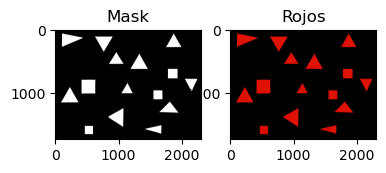

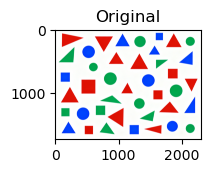

In [25]:
# Creamos una mascara binaria para detectar que pixeles estan dentro del rango de rojos establecido
# Los pixeles detectados dentro del rango de color rojo se imprimen en blanco (255) y el resto en negro (0)
mask_rojo = cv.inRange(image_hsv, min_rojo, max_rojo)

# Se ejecuta una operacion logica and entre la imagen original y la mascara de color rojo, asi segmentamos solo el color rojo de la imgen original.
resultado_rojo = cv.bitwise_and(image_rgb, image_rgb, mask = mask_rojo)

plt.subplot(1, 3, 1)
plt.imshow(mask_rojo, cmap = 'gray')
plt.title('Mask')
plt.subplot(1, 3, 2)
plt.imshow(resultado_rojo)
plt.title('Rojos')
plt.show()
plt.subplot(1, 3, 3)
plt.title('Original')
plt.imshow(image_rgb)
plt.show()

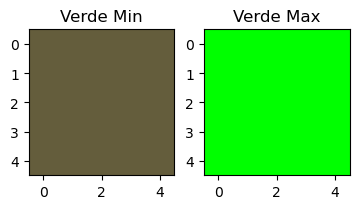

In [26]:
#Se establece el rango de color verde minimo y maximo ha ser detectado en espectro hsv 
min_verde = (35, 100, 100)
max_verde = (85, 255, 255)

#Se crean dos matrices con el color verde minimo y maximo establecido por el usuario 
matriz_verde_min = np.full((5, 5, 3), min_verde, dtype=np.uint8) / 255.0
matriz_verde_max = np.full((5, 5, 3), max_verde, dtype=np.uint8) / 255.0

plt.subplot(1, 3, 1)
plt.imshow(hsv_to_rgb(matriz_verde_min))
plt.title('Verde Min')
plt.subplot(1, 3, 2)
plt.imshow(hsv_to_rgb(matriz_verde_max))
plt.title('Verde Max')
plt.show()

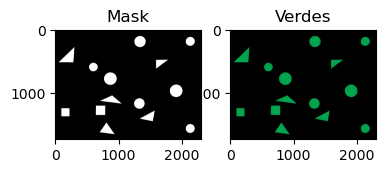

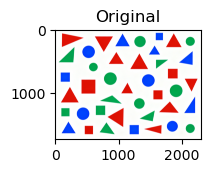

In [27]:
# Creamos una mascara binaria para detectar que pixeles estan dentro del rango de verdes establecido
# Los pixeles detectados dentro del rango de color verde se imprimen en blanco (255) y el resto en negro (0)
mask_verde = cv.inRange(image_hsv, min_verde, max_verde)

# Se ejecuta una operacion logica and entre la imagen original y la mascara de color verde, asi segmentamos solo el color verde de la imgen original.
resultado_verde = cv.bitwise_and(image_rgb, image_rgb, mask = mask_verde)

plt.subplot(1, 3, 1)
plt.imshow(mask_verde, cmap = 'gray')
plt.title('Mask')
plt.subplot(1, 3, 2)
plt.imshow(resultado_verde)
plt.title('Verdes')
plt.show()
plt.subplot(1, 3, 3)
plt.imshow(image_rgb)
plt.title('Original')
plt.show()

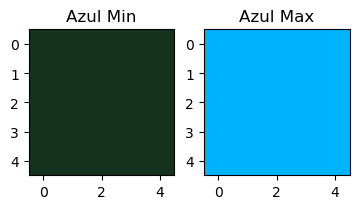

In [28]:
#Se establece el rango de color azul minimo y maximo ha ser detectado en espectro hsv 
min_azul = (100, 150, 50)
max_azul = (140, 255, 255)

#Se crean dos matrices con el color azul minimo y maximo establecido por el usuario 
matriz_azul_min = np.full((5, 5, 3), min_azul, dtype=np.uint8) / 255.0
matriz_azul_max = np.full((5, 5, 3), max_azul, dtype=np.uint8) / 255.0

plt.subplot(1, 3, 1)
plt.imshow(hsv_to_rgb(matriz_azul_min))
plt.title('Azul Min')
plt.subplot(1, 3, 2)
plt.imshow(hsv_to_rgb(matriz_azul_max))
plt.title('Azul Max')
plt.show()

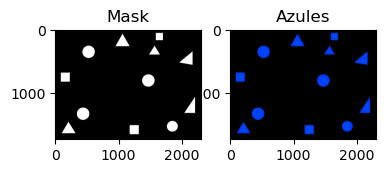

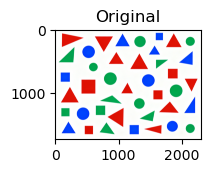

In [29]:
# Creamos una mascara binaria para detectar que pixeles estan dentro del rango de azules establecido
# Los pixeles detectados dentro del rango de color azul se imprimen en blanco (255) y el resto en negro (0)
mask_azul = cv.inRange(image_hsv, min_azul, max_azul)

# Se ejecuta una operacion logica and entre la imagen original y la mascara de color azul, asi segmentamos solo el color azul de la imgen original.
resultado_azul = cv.bitwise_and(image_rgb, image_rgb, mask = mask_azul)

plt.subplot(1, 3, 1)
plt.imshow(mask_azul, cmap = 'gray')
plt.title('Mask')
plt.subplot(1, 3, 2)
plt.imshow(resultado_azul)
plt.title('Azules')
plt.show()
plt.subplot(1, 3, 3)
plt.imshow(image_rgb)
plt.title('Original')
plt.show()

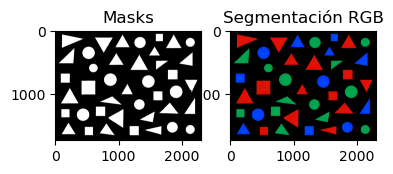

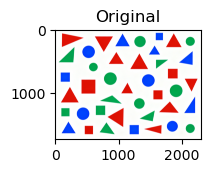

In [11]:
# Se suma las tres mascaras de color rojo, verde y azul en unaresultante
mask_rgb = mask_rojo + mask_verde + mask_azul

# Se ejecuta una operacion logica and entre la imagen original y la mascara resultante, asi segmentamos los colore rojo, verde y azul de la imgen original
resultado_rgb = cv.bitwise_and(image_rgb, image_rgb, mask = mask_rgb)

plt.subplot(1, 3, 1)
plt.imshow(mask_rgb, cmap="gray")
plt.title('Masks')
plt.subplot(1, 3, 2)
plt.imshow(resultado_rgb)
plt.title('Segmentación RGB')
plt.show()
plt.subplot(1, 3, 3)
plt.imshow(image_rgb)
plt.title('Original')
plt.show()